<a href="https://colab.research.google.com/github/ValeriaCastilloc/mydataproyects/blob/main/WebAnalyticsProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Emails of the team members:


- Valeria Castillo: valeria.castillocabanillas@edhec.com
- Cecilia Prada: cecilia.pradasobrino@edhec.com;
- Camilo Zuleta: camilo.zuletadezubiria@edhec.com;
- Sofia Herrera: Sofia.herrera@edhec.com;
- Jacobo Valderrama: Jacobo.valderramarovira@edhec.com;
- Juliana Leano: juliana.leano@edhec.com

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from scipy.stats import ttest_ind
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project='inlaid-chiller-442215-u9')

from google.colab import auth
auth.authenticate_user()
print('Authenticated')


Authenticated


# **Business problem 1: Should we create a differentiated landing page for the different US regions depending on the most successful product categories per site?**

In [ ]:
df2 = client.query('''WITH p1 AS (
  SELECT
    ecommerce.purchase_revenue_in_usd,
    item, geo
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`,
    UNNEST(items) AS item
  WHERE event_name = 'purchase'
  ORDER BY
    event_timestamp ASC
)
SELECT
  CASE
    WHEN geo.region IN ('Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut',
                        'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Maryland', 'Virginia',
                        'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida') THEN 'East'
    WHEN geo.region IN ('Ohio', 'Michigan', 'Indiana', 'Illinois', 'Wisconsin', 'Minnesota', 'Iowa',
                        'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas') THEN 'Central'
    WHEN geo.region IN ('California', 'Oregon', 'Washington', 'Alaska', 'Hawaii', 'Montana', 'Idaho',
                        'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Texas',
                        'Oklahoma', 'Arkansas', 'Louisiana') THEN 'West'
    ELSE 'Other'
  END AS region_classification,
  item.item_category,
  SUM(item.item_revenue_in_usd) AS sum_revenue
FROM
  p1
WHERE geo.country = 'United States'
  AND geo.region != '(not set)'
  AND geo.region IS NOT NULL
  AND item.item_category IS NOT NULL
  AND item.item_category != '(not set)'
  AND item.item_category != ''
GROUP BY
  region_classification, item.item_category
ORDER BY
  region_classification, sum_revenue DESC;
''').to_dataframe()

print(df2)

   region_classification            item_category  sum_revenue
0                Central                  Apparel       2025.0
1                Central                     Bags        387.0
2                Central                      New        259.0
3                Central        Campus Collection        248.0
4                Central            Shop by Brand        209.0
..                   ...                      ...          ...
56                  West                   Google         48.0
57                  West      Writing Instruments         37.0
58                  West     Notebooks & Journals         31.0
59                  West  Electronics Accessories         10.0
60                  West                      Fun          3.0

[61 rows x 3 columns]


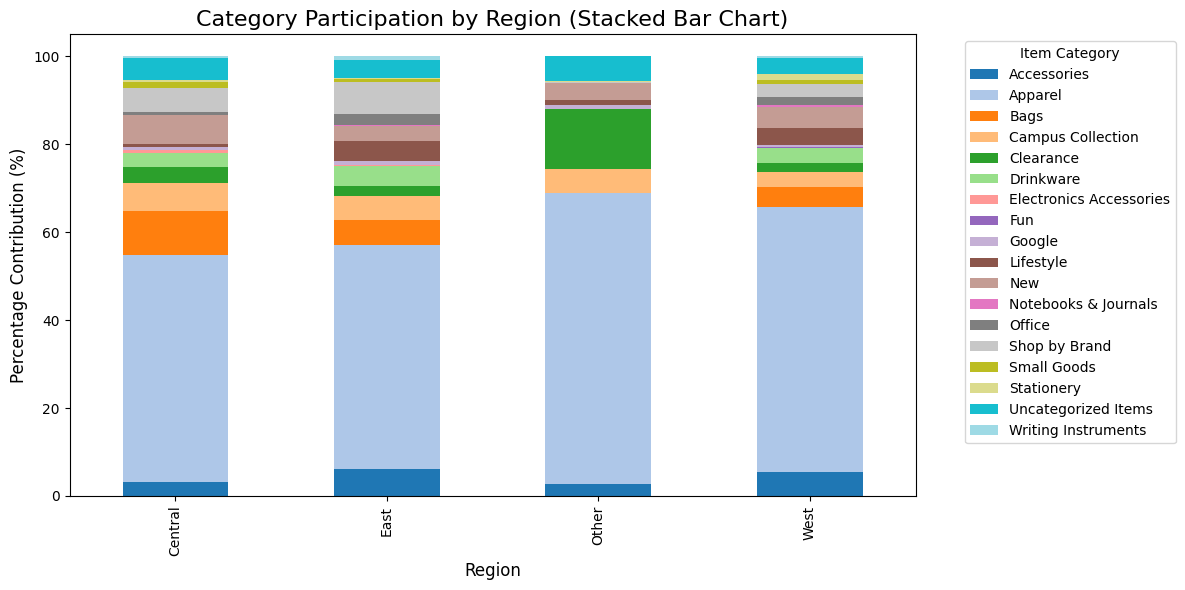

In [ ]:
# Normalize the revenue by region to calculate percentage contribution
df2['category_percentage'] = df2.groupby('region_classification')['sum_revenue'].transform(lambda x: (x / x.sum()) * 100)

# Pivot the data for a stacked bar chart
pivot_df = df2.pivot(index='region_classification', columns='item_category', values='category_percentage')

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

# Add chart labels and title
plt.title('Category Participation by Region (Stacked Bar Chart)', fontsize=16)
plt.ylabel('Percentage Contribution (%)', fontsize=12)
plt.xlabel('Region', fontsize=12)
plt.legend(title='Item Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the chart
plt.show()


In [ ]:
#ANOVA TEST

# Null hypothesis (H0): The region is not significant for revenue
# Alternative hypothesis (H1): The region is significant for revenue

# Group data by region and get the revenue values
groups = [
    df2[df2['region_classification'] == region]['sum_revenue'].values
    for region in df2['region_classification'].unique()
]

# Perform one-way ANOVA
anova_result = f_oneway(*groups)

# Output the results
print("ANOVA Test Results:")
print(f"F-statistic: {anova_result.statistic:.4f}")
print(f"P-value: {anova_result.pvalue:.4e}")

# Interpret the results
alpha = 0.05
if anova_result.pvalue < alpha:
    print("Result: Reject the null hypothesis (H0). Region significantly affects revenue.")
else:
    print("Result: Fail to reject the null hypothesis (H0). No significant effect of region on revenue.")


ANOVA Test Results:
F-statistic: 0.6915
P-value: 5.6102e-01
Result: Fail to reject the null hypothesis (H0). No significant effect of region on revenue.


### **Conclusion**: the success of the Apparel category across all regions suggests that a single, optimized landing page focused on apparel could be a more efficient and effective strategy. Creating separate landing pages for each region might not significantly improve sales and could introduce unnecessary complexity.

# **Business problem 2: should we delist any product inside categories? Is there any product inside a category with an extremely negative and low revenue that Google could consider delisting**



In [ ]:
# Creating a data frame with the category information
df_categories = client.query('''
SELECT
  items.item_category AS category_name,
  items.item_name AS product_name,
  SUM(ecommerce.purchase_revenue_in_usd) AS total_revenue_usd,
  SUM(ecommerce.total_item_quantity) AS total_quantity,
  SAFE_DIVIDE(SUM(ecommerce.purchase_revenue_in_usd), SUM(items.quantity)) AS average_price_per_unit,
  SUM(ecommerce.refund_value_in_usd) AS total_refund,
  EXTRACT(WEEK FROM TIMESTAMP_MICROS(event_timestamp)) AS sales_week,
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210115`,
  UNNEST(items) AS items
GROUP BY
  category_name, sales_week,
  product_name
''').to_dataframe()
print(df_categories)

Authenticated
          category_name                                product_name  \
0             (not set)                                   (not set)   
1                                  Google Beekeepers Youth Tee Pink   
2                           Google Badge Heavyweight Pullover Black   
3                   New                          Android Iconic Pin   
4                   New                    Google Cork Pencil Pouch   
...                 ...                                         ...   
1131      Home/Apparel/            Google Women's Puff Jacket Black   
1132            Apparel   Google Land & Sea French Terry Sweatshirt   
1133  Campus Collection                 Google SF Campus Ladies Tee   
1134  Campus Collection                 Google SF Campus Unisex Tee   
1135            Apparel  Google Women's Short Sleeve Hero Dark Grey   

      total_revenue_usd  total_quantity  average_price_per_unit  total_refund  \
0                   0.0            <NA>             

In [ ]:
# Getting to know the top 3 and bottom 3 products by category
import pandas as pd

# Create an empty list to store the summary
category_summaries = []

# Get unique category names
categories = df_categories['category_name'].unique()

# Iterate over each category
for category in categories:
    # Filter the data for the current category
    category_data = df_categories[df_categories['category_name'] == category].copy()
    # Fill NaN values with 0 for ranking purposes
    category_data['total_revenue_usd_filled'] = category_data['total_revenue_usd'].fillna(0)
    category_data['total_quantity_filled'] = category_data['total_quantity'].fillna(0)
    category_data['average_price_per_unit_filled'] = category_data['average_price_per_unit'].fillna(0)
    category_data['total_refund_filled'] = category_data['total_refund'].fillna(0)

     # Select the top 3 products by revenue
    top_3 = category_data.nlargest(3, 'total_revenue_usd_filled')[['product_name', 'total_revenue_usd','sales_week']]

    # Select the bottom 3 products by revenue, considering NaN and 0
    bottom_3 = category_data.nsmallest(3, 'total_revenue_usd_filled')[['product_name', 'total_revenue_usd','sales_week']]


    # Append top 3 products to the summary
    for _, row in top_3.iterrows():
        category_summaries.append({
            "category_name": category,
            "product_name": row['product_name'],
            "revenue": row['total_revenue_usd'],
            "rank": "Top 3",
            "sales_week": row['sales_week']})

    # Append bottom 3 products to the summary
    for _, row in bottom_3.iterrows():
        category_summaries.append({
            "category_name": category,
            "product_name": row['product_name'],
            "revenue": row['total_revenue_usd'],
            "rank": "Bottom 3"
            })

# Convert the list of summaries to a DataFrame
summary_df = pd.DataFrame(category_summaries)

# Display the summary
#print(summary_df)

summary_df.head(100)

,category_name,product_name,revenue,rank,sales_week
0,(not set),(not set),0.0,Top 3,2.0
1,(not set),(not set),0.0,Bottom 3,NaN
2,,Google Beekeepers Youth Tee Pink,NaN,Top 3,2.0
3,,Google Badge Heavyweight Pullover Black,NaN,Top 3,2.0
4,,Google Crewneck Sweatshirt Grey,NaN,Top 3,2.0
...,...,...,...,...,...
95,Home/Campus Collection/,Google SF Campus Zip Hoodie,NaN,Bottom 3,NaN
96,Home/Campus Collection/,Google SF Campus Ladies Tee,NaN,Bottom 3,NaN
97,Home/Campus Collection/,Google Austin Campus Bottle,NaN,Bottom 3,NaN
98,Writing Instruments,Google Light Pen Green,43.0,Top 3,2.0


In [ ]:
# Filter for 'Bottom 3' in rank and sales_week with NaN or 0
filtered_df = summary_df[
    (summary_df['rank'] == 'Bottom 3') &
    (summary_df['sales_week'].isna() | (summary_df['sales_week'] == 0))
]

# Display the filtered DataFrame
print(filtered_df)

         category_name                             product_name  revenue  \
1            (not set)                                (not set)      0.0   
5                              Google Beekeepers Youth Tee Pink      NaN   
6                       Google Badge Heavyweight Pullover Black      NaN   
7                               Google Crewneck Sweatshirt Grey      NaN   
11                 New                       Android Iconic Pin      NaN   
..                 ...                                      ...      ...   
295            Writing              Google Recycled Writing Set      NaN   
299  Women's T-Shirts/      Google F/C Long Sleeve Tee Charcoal      NaN   
300  Women's T-Shirts/                     Google Eco Tee Black      NaN   
301  Women's T-Shirts/                     Google Dino Game Tee      NaN   
303               Hats             Google Land & Sea Cotton Cap      NaN   

         rank  sales_week  
1    Bottom 3         NaN  
5    Bottom 3         NaN  
6  

In [ ]:
# Export the filtered DataFrame to an Excel file
filtered_df.to_excel('filtered_products.xlsx', index=False)

print("Filtered data has been exported to 'filtered_products.xlsx'")

### **Recommendation:** With the actual result, we found 152 products that are candidates for delisting, they are the worst performers in their categories. It is recommended to complete the database with margin data to analyze net profit by product before making final decisions.

#  **Business problem 3: Which traffic sources have the highest conversion rates, and how can marketing efforts be adjusted accordingly? Which are the traffic sources that I should prioritize for improving?**

In [ ]:
# Query to fetch the data from BigQuery
df1 = client.query('''
SELECT
  traffic_source.source AS session_source,
  traffic_source.medium AS session_medium,
  COUNT(*) AS total_sessions,  -- Count the total number of sessions
  SUM(ecommerce.purchase_revenue_in_usd) AS total_revenue,
  SUM(ecommerce.purchase_revenue_in_usd) / SUM(SUM(ecommerce.purchase_revenue_in_usd)) OVER () * 100 AS revenue_percentage
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
  event_name = 'purchase'
GROUP BY
  session_source, session_medium
ORDER BY
  total_revenue DESC;
''').to_dataframe()

# Replace <Other> in session_source with the corresponding session_medium
df1['session_source'] = df1.apply(
    lambda row: row['session_medium'] if row['session_source'] == '<Other>' else row['session_source'], axis=1
)

# Replace 'shop.googlemerchandisestore.com' with 'referral'
df1['session_source'] = df1['session_source'].replace('shop.googlemerchandisestore.com', 'web page referral')

# Group rows that have (data deleted) into <Other>
df1['session_source'] = df1['session_source'].apply(
    lambda x: '<Other>' if '(data deleted)' in x else x
)

# Remove rows where session_source is still <Other> and (data deleted) if needed (optional step)
df1_filtered = df1[df1['session_source'] != '(data deleted)']

# Group by session_source and aggregate total sessions and total revenue
df1_grouped = df1_filtered.groupby('session_source').agg(
    total_sessions=('total_sessions', 'sum'),
    total_revenue=('total_revenue', 'sum'),
    revenue_percentage=('revenue_percentage', 'sum')  # Or adjust this calculation as needed
).reset_index()

# Calculate the total sessions across all sources
total_sessions_all_sources = df1_grouped['total_sessions'].sum()

# Add a new column for sessions percentage
df1_grouped['sessions_percentage'] = (df1_grouped['total_sessions'] / total_sessions_all_sources) * 100

# Calculate Conversion Rate and add it to df1_grouped
df1_grouped['conversion_rate'] = (df1_grouped['total_revenue'] / df1_grouped['total_sessions']) * 100

# Print the result with the conversion rate included
print(df1_grouped[['session_source', 'total_sessions', 'total_revenue', 'conversion_rate', 'revenue_percentage']])

      session_source  total_sessions  total_revenue  conversion_rate  \
0           (direct)             269        12284.0      4566.542751   
1            <Other>             280        12134.0      4333.571429   
2             google             348        17871.0      5135.344828   
3            organic              27          908.0      3362.962963   
4           referral             115         6125.0      5326.086957   
5  web page referral             165         8028.0      4865.454545   

   revenue_percentage  
0           21.419355  
1           21.157803  
2           31.161290  
3            1.583261  
4           10.680035  
5           13.998256  


<ipython-input-87-6df5fd21d499>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='session_source', y='conversion_rate', data=df1_grouped, palette='viridis')


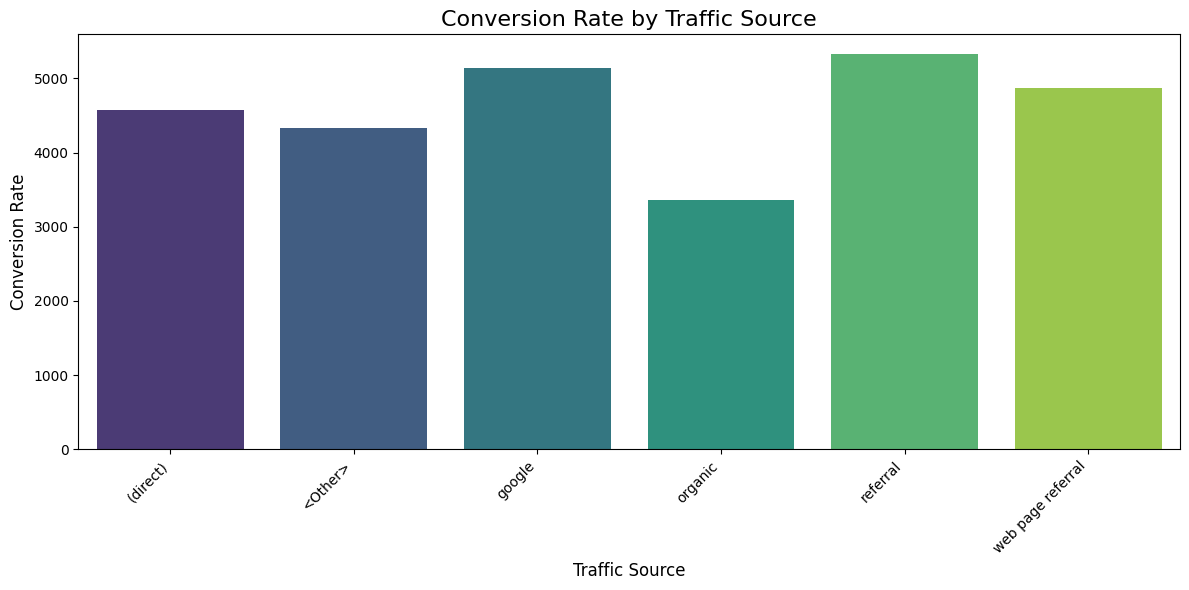

In [ ]:
# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the barplot with seaborn
sns.barplot(x='session_source', y='conversion_rate', data=df1_grouped, palette='viridis')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and labels
plt.title('Conversion Rate by Traffic Source', fontsize=16)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# ANOVA

# Null hypothesis (H0): All traffic sources have the same mean revenue.
# Alternative hypothesis (H1): At least one traffic source has a different mean revenue.


groups = [group['conversion_rate'].values for _, group in df1_grouped.groupby('session_source')]

# Perform the Kruskal-Wallis test
kruskal_result = stats.kruskal(*groups)
print(f"Kruskal-Wallis test result: H-statistic = {kruskal_result.statistic}, p-value = {kruskal_result.pvalue}")

p_value=kruskal_result.pvalue

if p_value > 0.05:
  print('The test result suggests that there is no significant difference between the revenue of each traffic session')
else:
  print('The test result suggests that there is a significant difference between the revenue of each traffic session')

Kruskal-Wallis test result: H-statistic = 5.0, p-value = 0.4158801869955079
The test result suggests that there is no significant difference between the revenue of each traffic session


**Conclusion: Taking into account the traffic sources results and impact in terms of revenue and conversion rate, we suggest the following marketing actions:**

*   **Referral traffic**: The company should explore more strategic partnerships and, affiliate marketing.
*   **Google**: Google source is the most important revenue and conversion rate contributor. They should consider scaling it by using paid campaigns.
*   **Direct**: The company should consider leveraging retargeting strategies, personalized offers, and loyalty programs to improve conversion.
*    **Organic search**: The company could focus on improving SEO (Search Engine Optimization) efforts to increase traffic and conversion from.
*   **Others**: Investigate the others category, which could represent unknown sources or sources you haven't fully optimized.


# **Business problem 4: how to create a promotional strategy to boost sales by week and month**

In [ ]:
# Revenue by product, category and date
df_revenue_product = client.query('''
SELECT
  items.item_category AS category,
  items.item_name AS product_name,
  SUM(items.price * items.quantity) AS total_revenue,
  FORMAT_TIMESTAMP('%Y-%m-%d', TIMESTAMP_MICROS(event_timestamp)) AS sales_date
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`,
     UNNEST(items) AS items
WHERE event_name = 'purchase'
  AND EXTRACT(MONTH FROM TIMESTAMP_MICROS(event_timestamp)) = 1
GROUP BY category, product_name, sales_date
ORDER BY total_revenue DESC
''').to_dataframe()
print(df_revenue_product)


        category                       product_name  total_revenue  sales_date
0     Gift Cards                 Gift Card- $100.00         1200.0  2021-01-19
1        Apparel  Google Sherpa Zip Hoodie Charcoal          550.0  2021-01-20
2        Apparel      Google Men's Tech Fleece Grey          426.0  2021-01-14
3        Apparel   Google Crewneck Sweatshirt Green          418.0  2021-01-21
4        Apparel   Google Crewneck Sweatshirt Green          396.0  2021-01-20
...          ...                                ...            ...         ...
1821   (not set)                          (not set)            NaN  2021-01-14
1822   (not set)                          (not set)            NaN  2021-01-12
1823   (not set)                          (not set)            NaN  2021-01-16
1824   (not set)                          (not set)            NaN  2021-01-27
1825   (not set)                          (not set)            NaN  2021-01-20

[1826 rows x 4 columns]


In [ ]:
# Total revenue by day
df_revenue_by_day_january = client.query('''
SELECT
  FORMAT_TIMESTAMP('%Y-%m-%d', TIMESTAMP_MICROS(event_timestamp)) AS sales_date,
  SUM(items.price * items.quantity) AS total_revenue
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`,
     UNNEST(items) AS items
WHERE event_name = 'purchase'
AND EXTRACT(MONTH FROM TIMESTAMP_MICROS(event_timestamp)) = 1
GROUP BY sales_date
ORDER BY sales_date ASC;

''').to_dataframe()
print(df_revenue_by_day_january)


    sales_date  total_revenue
0   2021-01-01          973.0
1   2021-01-02         1027.0
2   2021-01-03          540.0
3   2021-01-04          833.0
4   2021-01-05         1143.0
5   2021-01-06         2002.0
6   2021-01-07         1450.0
7   2021-01-08         1702.0
8   2021-01-09         1360.0
9   2021-01-10          975.0
10  2021-01-11         1496.0
11  2021-01-12         2545.0
12  2021-01-13         1860.0
13  2021-01-14         3266.0
14  2021-01-15         2070.0
15  2021-01-16         1460.0
16  2021-01-17          479.0
17  2021-01-18         1221.0
18  2021-01-19         3753.0
19  2021-01-20         6689.0
20  2021-01-21         4237.0
21  2021-01-22         5544.0
22  2021-01-23         2741.0
23  2021-01-24         2403.0
24  2021-01-25         3353.0
25  2021-01-26         1257.0
26  2021-01-27          465.0
27  2021-01-28          129.0
28  2021-01-29          180.0
29  2021-01-30          160.0
30  2021-01-31            NaN


In [ ]:
# Finding the days with more traffic
df_days_with_more_traffic = client.query('''
SELECT
  FORMAT_TIMESTAMP('%Y-%m-%d', TIMESTAMP_MICROS(event_timestamp)) AS traffic_date,
  COUNT(DISTINCT user_pseudo_id) AS unique_users
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE event_name ='purchase'
AND EXTRACT(MONTH FROM TIMESTAMP_MICROS(event_timestamp)) = 1
GROUP BY traffic_date
ORDER BY traffic_date ASC;

''').to_dataframe()
print(df_days_with_more_traffic)


   traffic_date  unique_users
0    2021-01-01            12
1    2021-01-02            14
2    2021-01-03            14
3    2021-01-04            16
4    2021-01-05            27
5    2021-01-06            28
6    2021-01-07            25
7    2021-01-08            34
8    2021-01-09            18
9    2021-01-10            14
10   2021-01-11            26
11   2021-01-12            43
12   2021-01-13            34
13   2021-01-14            47
14   2021-01-15            38
15   2021-01-16            23
16   2021-01-17            14
17   2021-01-18            18
18   2021-01-19            47
19   2021-01-20            94
20   2021-01-21            49
21   2021-01-22            86
22   2021-01-23            42
23   2021-01-24            35
24   2021-01-25            58
25   2021-01-26            51
26   2021-01-27            49
27   2021-01-28            56
28   2021-01-29            51
29   2021-01-30            28
30   2021-01-31            17


<Axes: xlabel='day_only', ylabel='unique_users'>

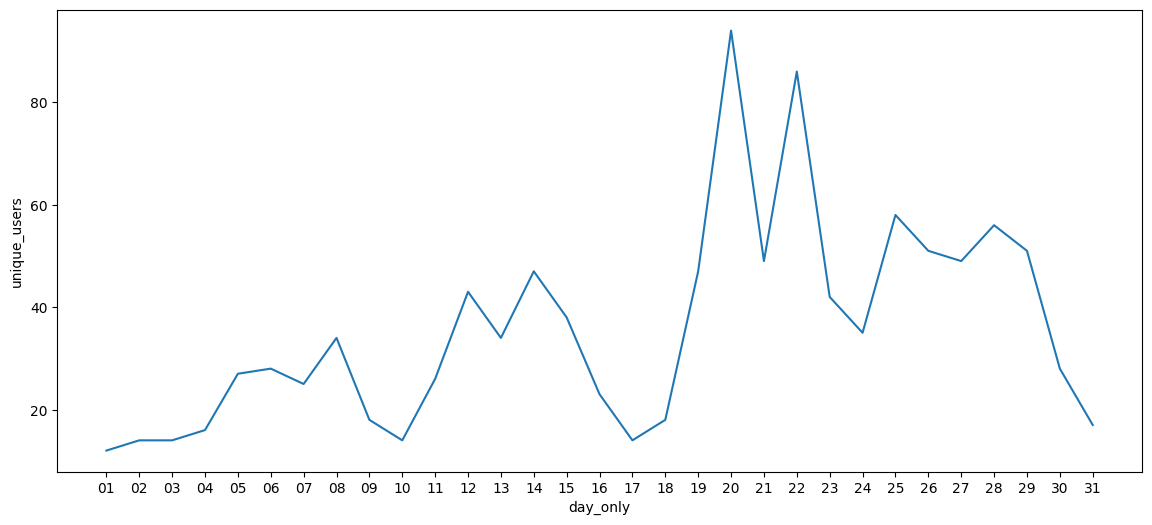

In [ ]:
# in this next section we will do the graphs to  show the information on the dataframes more clear
df_days_with_more_traffic['traffic_date'] = pd.to_datetime(df_days_with_more_traffic['traffic_date'])

df_days_with_more_traffic['day_only'] = df_days_with_more_traffic['traffic_date'].dt.strftime('%d')

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_days_with_more_traffic,x=df_days_with_more_traffic["day_only"],y=df_days_with_more_traffic["unique_users"])


<Axes: xlabel='day', ylabel='total_revenue'>

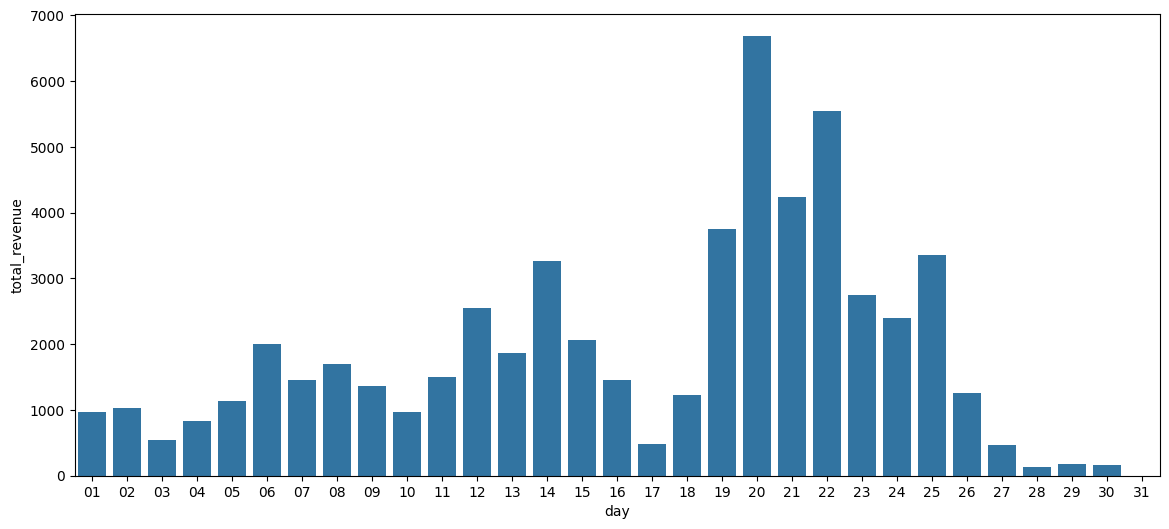

In [ ]:
df_revenue_by_day_january['sales_date'] = pd.to_datetime(df_revenue_by_day_january['sales_date'])

df_revenue_by_day_january['day'] = df_revenue_by_day_january['sales_date'].dt.strftime('%d')

plt.figure(figsize=(14, 6))
sns.barplot(data=df_revenue_by_day_january,x=df_revenue_by_day_january["day"],y=df_revenue_by_day_january["total_revenue"])


### **Conclusion:** January 20, 2021, had the highest revenue, reaching $6,689. This also coincided with the day having the most active users, with 94 people purchasing a specific product. Looking at the pattern, this peak aligns with the days right after people typically get paid. In contrast, before the 15th of the month, the number of active users and the daily revenue tend to be lower. To boost revenue during this slower period, it would be beneficial to offer more promotions and discounts in the first half of the month.

# **Business problem 5: what are the most relevant product combinations to create a promotional strategy ?**

In [ ]:
df_product_pairs = client.query('''
SELECT
a.item_name AS product_1,
b.item_name AS product_2,
COUNT(*) AS pair_count
FROM
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`,
UNNEST(items) AS a,
UNNEST(items) AS b
WHERE
event_name = 'purchase'
AND a.item_name < b.item_name
GROUP BY
product_1, product_2
ORDER BY
pair_count DESC
LIMIT 10;
''').to_dataframe()

print(df_product_pairs)

                               product_1  \
0                 Google Light Pen Green   
1          Google Black Cloud Zip Hoodie   
2          Google Men's Tech Fleece Grey   
3                  Google Light Pen Blue   
4       Google Crewneck Sweatshirt Green   
5                  Google Light Pen Blue   
6          Google Sherpa Zip Hoodie Navy   
7          Google Black Cloud Zip Hoodie   
8          Google Men's Tech Fleece Grey   
9  Google Laptop and Cell Phone Stickers   

                               product_2  pair_count  
0                   Google Light Pen Red           9  
1           Google Metallic Notebook Set           9  
2          Google Sherpa Zip Hoodie Navy           9  
3                 Google Light Pen Green           8  
4      Google Sherpa Zip Hoodie Charcoal           8  
5                   Google Light Pen Red           8  
6                  Google Zip Hoodie F/C           8  
7  Google Laptop and Cell Phone Stickers           8  
8                  G

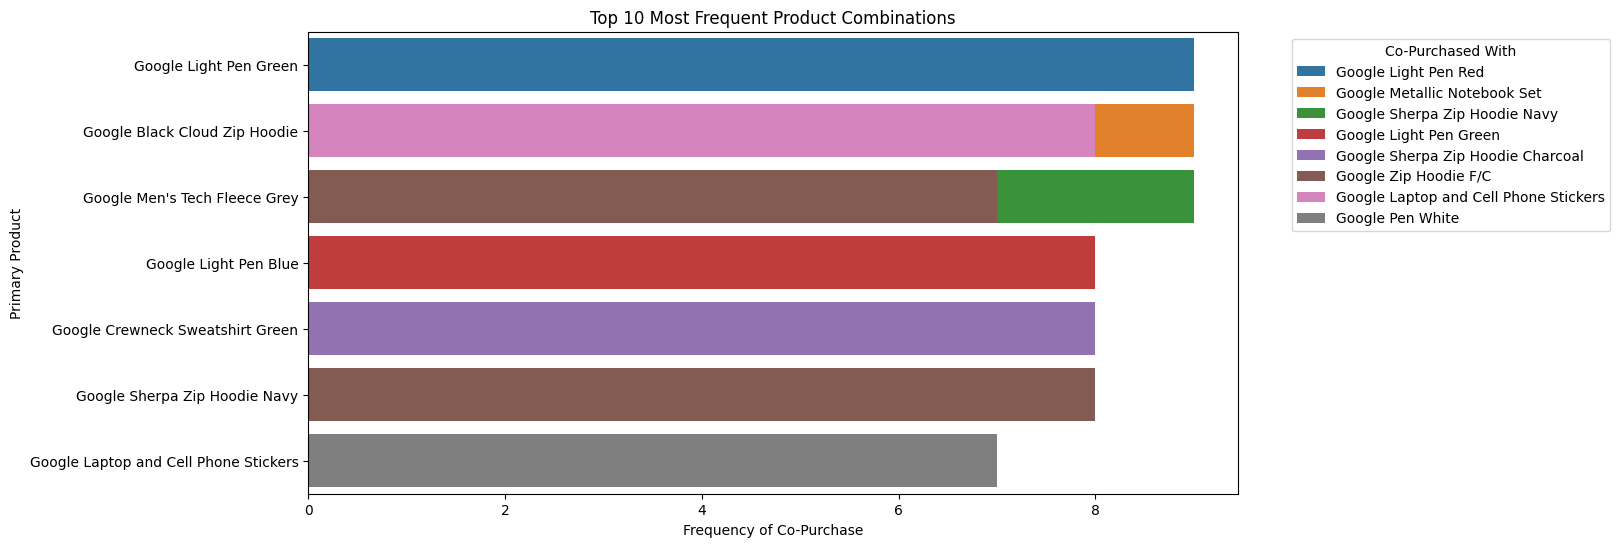

In [ ]:
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.barplot(data=df_product_pairs, x='pair_count', y='product_1', hue='product_2', dodge=False)
plt.title('Top 10 Most Frequent Product Combinations')
plt.xlabel('Frequency of Co-Purchase')
plt.ylabel('Primary Product')
plt.legend(title='Co-Purchased With', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### **Conclusion:** The analysis shows that products like the Google Light Pen Green and Red, as well as Google Sherpa Zip Hoodies, are often co-purchased, highlighting bundling opportunities. Promoting these combinations through discounts or recommendations can boost sales and customer convenience. Ensuring paired items stay in stock and leveraging cross-selling strategies will further enhance marketing efforts and customer satisfaction.

### **CHAT GPT PROMPTS:**

*   How to perform the ANOVA test to evaluate the significance of the regions in the products revenue?
*   How to use a stack bar to graph the selling by categories in each US region?
*   How to perform the ANOVA test to evaluate the significance of the traffic source in the products revenue?
*   How to find and graph the best product combinations that were bought the most times together?
*   How to find the best-selling products by category?
*   How to rename the traffic sources and combine all of them that are related to referrals and others?
*   How can I identify the days with the most traffic on the page where the event_name is "purchase"?
*  How to calculate the sales date by using the timestamp variable?
*   I want to extract the day from the date in one of the queries to improve the graph's readability—one graph showing revenue by day and another displaying active users by day.













